In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
import mercury as mr

# configure app properties
app = mr.App(title="Static notebook", description="Display static notebook", static_notebook=True)

mercury.App

## Introduction and Motivation 

Dengue fever, a mosquito-borne viral disease, poses a significant threat to public health, particularly in tropical and subtropical regions. As climate change progresses, the geographic distribution of the Aedes aegypti mosquito—the primary vector for dengue—and other mosquitos like Aedes albopictus extend into new areas, increasing the risk of outbreaks in regions previously considered safe. This report examines what the future distribution of Dengue fever will look like. 

Utilizing historical data, I have constructed a supervised machine learning model to predict what dengue cases will look like for 100 countries in 2026. There is also an unsupervised model that classifies dengue pr

There is also traditional EDA illustrating which countries are struggling the most with dengue caseloads .  

The motivation behind this study lies in the urgent need to raise awareness about the expanding risk of dengue fever as climate change intensifies. In many jurisdictions, monitoring and reporting systems are inadequate, leaving medical professionals and concerned citizens without the tools necessary to prepare for and respond to outbreaks effectively. By highlighting vulnerable regions and predicting dengue transmission trends, this report aims to provide valuable information that can support healthcare initiatives and guide policy decisions in a rapidly warming world.

### Dengue in 5 Questions 

Which countries of the world are now experiencing the most Dengue fever?

Which countries are at climate risk for Dengue in the future? 

How does the current Dengue epidemic in Brazil compare to previous Dengue epidemics? 

Which countries have been able to reduce Dengue cases in recent years, and which countries are struggling to do so? 

Given sufficient historical data, can we predict the number of Dengue cases by country? 


## Literature Review 

Outside of academic sources, this project was largely inspired by this Guardian article documenting the impact of Dengue in Burkina Faso. While I had heard of it before, I had not realized the sheer geographical range of Dengue fever, sometimes also called breakbone fever because of how severe the joint pain is for many patients. While I read many sources in the process of making this, here is a condensed summary of the best academic resources I found. <br> 

The impact of Dengue in the tropics goes back centuries and is well documented. The term breakbone fever was coined in the 1800s by Dr. Benjamin Rush. The earliest case in history was recorded in China around 300 BCE, but was not extensively studied in the West until it became a bigger problem in Panama and the French-occupied West Indies in the 17th century[1]. <br>

More recently, global warming has expanded the range of multiple mosquitos that are known carriers for this disease, making more and more non-tropical countries susceptible to local epidemics of Dengue. New studies out of Iran estimate that dengue could become a much bigger problem in Southwest Asia soon [2]. Others point out that even regions that are neither southern nor tropical are at risk, because many woodlands are also prone to humidity if they are coastal enough, and that the biggest predictor of Dengue is humidity and heat.[3] <br>

There have been a few attempts to forecast dengue, but likely due to financial and politicial factors, they have been limited to specific countries and not to global settings. The most relevant one I could find was this paper out of Brazil, which accomplished the task using Ensemble Methods, particularly SVMs.[4]. 

Citations:
1: History of Dengue, Dengue Virus Net
2: Karami H. et al, Dengue fever in Iran: An emerging threat requiring urgent public health interventions. New Microbes New Infect. Nov 2024
3: Piedrahita A. R. et al.Spatio-temporal forecasting of dengue in the Americas through hybrid mechanistic and data-driven models: Systematic review and meta-analysis: Infectious Disease Modelling,Volume 11, Issue 2,2026
4: Buczak, A. L. et al. Ensemble method for dengue prediction. PLoS ONE 13, e0189988 (2018)








<h1>Data Collection and Cleaning</h1>

The majority of the data for this analysis was pulled from the OpenDengue Project archives. While I recognize that the data is imperfect because countries and regions are responsible for their own reporting, this is by far the most comprehensive global dataset I could find on the distribution of dengue fever.</p>

<p>This dataset is clean for the most part. However, there are some data aggregation and encoding issues as not all annual data is labelled as such even if it was collected. There are also many redundant columns because the various organizations that partner with ODP have different naming conventions for countries, territories and regions. In hindsight, integration with the mapping software Folium would have been easier if I had started by labeling countries with their full names in appropriate English casing (eg. 'Afghanistan') instead of using the upper case full_name variable or the ISO code (eg. 'AFG'). However. workarounds have been implemented to account for Folium's inflexibility. Personally, I actually prefer ISO codes because they are faster to read and less prone to being misunderstood if you have experience working with them (I used to work with data like this all the time). The biggest issue with this data is that some years are entirely missing. I did not have sufficient time to come up with an imputation strategy, however, the models work fine and the trends found are both easy to see and consistent with expectations, so I'm not too worried about it.</p>

<p>The second dataset used was from the World Bank, it containst humid heat projections for future years. While precipitation, humid heat, and surface temperature have all been found to correlate with dengue outbreaks, I chose to use humidity because it was mentioned in a greater number of studies. Surface temperature isn't as reliable because high heat can kill mosquitoes past s certain level, and precipitation patterns are often trickier to predict over time. The data was clean and only needed minor naming-convention alterations.The climate model used to generate this data was CMIMP0.25.</p>

<p>About CMIMP0.25: CMIMP (Coupled Model Intercomparison Project) is an ongoing collaborative framework of climate models implemented to improve knowledge of climate change. It was organized in 1995 by the Working Group on Coupled Modelling (WGCM) of the World Climate Research Programme (WCRP). It is developed in phases to foster the climate model improvements but also to support national and international assessments of climate change. This particular version has a 0.25-degree resolution allows for more detailed simulations of climate phenomena, capturing finer-scale processes that occur in the atmosphere, oceans, and land surfaces. This level of detail can improve understanding of local climate impacts.The model integrates various components of the Earth’s climate system, including the atmosphere, oceans, land surface, and ice. This coupling enhances the accuracy of predictions by considering interactions between different environmental elements.Its high resolution makes it particularly useful for regional climate studies, aiding in the assessment of localized climate adaptation strategies and informing actions on issues like water resource management, agriculture, and disaster preparedness. </p>

<p>The World Bank is a major global institution established to provide financial and technical assistance to developing countries, with a mission to reduce poverty and promote sustainable economic development. I love using their datasets because I know the people who work there and I can always trust them to put out a quality product. The WB handles both the International Bank for Reconstruction and Development (IBRD) and the International Development Association (IDA). They also fund various projects aimed at improving infrastructure, education, health care, and agriculture, while also addressing massive global challenges like climate change. While there are a million datasets out there for this kind of thing, I like that theirs uses a naming convention which, when the capitalization is corrected, is compatible with a lot of major mapmaking and graphing tools like GeoJSON on top of which both Geopandas and Folium are built. 

    
<h1>Dimension Reduction</h1>

<p>While I was confident in selecting the variables that I did for this process, I also implemented PCA (Principle Component Analysis) to see how it would rank the features I selected. Unsurprisingly, PCA also agreed that the year, one naming variable per country, and one case count per country, was sufficient to move this analysis forward. Nevertheless, it was a good exercise.</p>

<p>I chose to use PCA over T-SNE (T-distributed Stochastic Neighbor Embedding) because I find that PCA is more intrepretable and generally easy to code. The feature_names function in python makes it easy to see which features have "surfaced" to the top of my component list without having to build and interpret a graph. I also find that PCA is a lot more commonplace in industry and had honestly never heard of T-SNE before starting my graduate program.</p>




In [3]:
cases = pd.read_csv('data/National_extract_V1_3.csv')

In [4]:
cases

,adm_0_name,adm_1_name,adm_2_name,full_name,ISO_A0,FAO_GAUL_code,RNE_iso_code,IBGE_code,calendar_start_date,calendar_end_date,Year,dengue_total,case_definition_standardised,S_res,T_res,UUID
0,AFGHANISTAN,NaN,NaN,AFGHANISTAN,AFG,1011446,AFG,NaN,2021-09-05,2021-09-11,2021,18.0,Suspected,Admin0,Week,WHOEMRO-ALL-2021-Y01-05
1,AFGHANISTAN,NaN,NaN,AFGHANISTAN,AFG,1011446,AFG,NaN,2021-09-12,2021-09-18,2021,24.0,Suspected,Admin0,Week,WHOEMRO-ALL-2021-Y01-05
2,AFGHANISTAN,NaN,NaN,AFGHANISTAN,AFG,1011446,AFG,NaN,2021-09-19,2021-09-25,2021,9.0,Suspected,Admin0,Week,WHOEMRO-ALL-2021-Y01-05
3,AFGHANISTAN,NaN,NaN,AFGHANISTAN,AFG,1011446,AFG,NaN,2021-09-26,2021-10-02,2021,104.0,Suspected,Admin0,Week,WHOEMRO-ALL-2021-Y01-05
4,AFGHANISTAN,NaN,NaN,AFGHANISTAN,AFG,1011446,AFG,NaN,2021-10-03,2021-10-09,2021,98.0,Suspected,Admin0,Week,WHOEMRO-ALL-2021-Y01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29868,YEMEN,NaN,NaN,YEMEN,YEM,269,YEM,NaN,2024-06-23,2024-06-29,2024,139.0,Suspected and confirmed,Admin0,Week,LITERATURE-YEM-20202024-Y01-00
29869,YEMEN,NaN,NaN,YEMEN,YEM,269,YEM,NaN,2024-06-30,2024-07-06,2024,124.0,Suspected and confirmed,Admin0,Week,LITERATURE-YEM-20202024-Y01-00
29870,YEMEN,NaN,NaN,YEMEN,YEM,269,YEM,NaN,2024-07-07,2024-07-13,2024,121.0,Suspected and confirmed,Admin0,Week,LITERATURE-YEM-20202024-Y01-00
29871,YEMEN,NaN,NaN,YEMEN,YEM,269,YEM,NaN,2024-07-14,2024-07-20,2024,121.0,Suspected and confirmed,Admin0,Week,LITERATURE-YEM-20202024-Y01-00


In [5]:
humidity_df = pd.read_excel('./climate_data/cmip6-x0.25_climatology_hurs_climatology_annual_2020-2039_median_ssp119_ensemble_all_mean.xlsx')
humidity_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   code     246 non-null    object 
 1   name     246 non-null    object 
 2   2020-07  246 non-null    float64
dtypes: float64(1), object(2)
memory usage: 5.9+ KB


In [6]:
cases['T_res'].value_counts()

T_res
Week     23248
Year      3495
Month     3130
Name: count, dtype: int64

In [7]:
# num countries?
cases['full_name'].value_counts()

full_name
NICARAGUA                   897
PERU                        813
SINGAPORE                   793
MEXICO                      711
COLOMBIA                    671
                           ... 
MAYOTTE                      10
CHAD                          9
CENTRAL AFRICAN REPUBLIC      7
REUNION                       7
GUINEA                        7
Name: count, Length: 129, dtype: int64

In [8]:
# looks like we have 129 countries 
cases['full_name'].nunique()

129

In [9]:
cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29873 entries, 0 to 29872
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   adm_0_name                    29873 non-null  object 
 1   adm_1_name                    0 non-null      float64
 2   adm_2_name                    0 non-null      float64
 3   full_name                     29873 non-null  object 
 4   ISO_A0                        29873 non-null  object 
 5   FAO_GAUL_code                 29873 non-null  int64  
 6   RNE_iso_code                  29873 non-null  object 
 7   IBGE_code                     0 non-null      float64
 8   calendar_start_date           29873 non-null  object 
 9   calendar_end_date             29873 non-null  object 
 10  Year                          29873 non-null  int64  
 11  dengue_total                  29873 non-null  float64
 12  case_definition_standardised  29873 non-null  object 
 13  S

In [10]:
annual_cases = cases.query('T_res == "Year" & case_definition_standardised == "Total"')

In [11]:
annual_cases

,adm_0_name,adm_1_name,adm_2_name,full_name,ISO_A0,FAO_GAUL_code,RNE_iso_code,IBGE_code,calendar_start_date,calendar_end_date,Year,dengue_total,case_definition_standardised,S_res,T_res,UUID
94,AMERICAN SAMOA,NaN,NaN,AMERICAN SAMOA,ASM,5,ASM,NaN,1955-01-01,1955-12-31,1955,0.0,Total,Admin0,Year,TYCHO-ALL-19242017-SV_DF01-00
95,AMERICAN SAMOA,NaN,NaN,AMERICAN SAMOA,ASM,5,ASM,NaN,1979-01-01,1979-12-31,1979,0.0,Total,Admin0,Year,TYCHO-ALL-19242017-SV_DF01-00
96,AMERICAN SAMOA,NaN,NaN,AMERICAN SAMOA,ASM,5,ASM,NaN,1980-01-01,1980-12-31,1980,1.0,Total,Admin0,Year,TYCHO-ALL-19242017-SV_DF01-00
97,AMERICAN SAMOA,NaN,NaN,AMERICAN SAMOA,ASM,5,ASM,NaN,1981-01-01,1981-12-31,1981,1.0,Total,Admin0,Year,TYCHO-ALL-19242017-SV_DF01-00
98,AMERICAN SAMOA,NaN,NaN,AMERICAN SAMOA,ASM,5,ASM,NaN,1982-01-01,1982-12-31,1982,0.0,Total,Admin0,Year,TYCHO-ALL-19242017-SV_DF01-00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29291,WALLIS AND FUTUNA,NaN,NaN,WALLIS AND FUTUNA,WLF,266,WLF,NaN,2008-01-01,2008-12-31,2008,0.0,Total,Admin0,Year,TYCHO-ALL-19242017-SV_DF01-00
29292,WALLIS AND FUTUNA,NaN,NaN,WALLIS AND FUTUNA,WLF,266,WLF,NaN,2009-01-01,2009-12-31,2009,13.0,Total,Admin0,Year,TYCHO-ALL-19242017-SV_DF01-00
29296,WALLIS AND FUTUNA,NaN,NaN,WALLIS AND FUTUNA,WLF,266,WLF,NaN,2013-01-01,2013-12-31,2013,94.0,Total,Admin0,Year,LITERATURE-ALL-20112019-Y01-02
29297,WALLIS AND FUTUNA,NaN,NaN,WALLIS AND FUTUNA,WLF,266,WLF,NaN,2017-01-01,2017-12-31,2017,222.0,Total,Admin0,Year,LITERATURE-ALL-20112019-Y01-02


In [12]:
### PCA ZONE ###

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [14]:
# PCA dislikes nulls, and dates, won't need these anyway
DF = cases.copy()
d = ['adm_0_name', 'adm_1_name','adm_2_name','calendar_start_date','calendar_end_date','IBGE_code']
DF = DF.drop(d, axis=1)


# too many text cols
numeric_features = ['FAO_GAUL_code', 'Year', 'dengue_total']
categorical_features = ['full_name','ISO_A0','RNE_iso_code','case_definition_standardised', 'S_res', 'T_res','UUID']

# encoding for categorical features
ohe = OneHotEncoder(sparse=False)
encoded_cats = ohe.fit_transform(DF[['full_name','ISO_A0','RNE_iso_code','case_definition_standardised', 'S_res', 'T_res','UUID']])
encoded_df = pd.DataFrame(encoded_cats, columns=ohe.get_feature_names_out(categorical_features))

# combine numeric features with encoded categorical features
df_encoded = pd.concat([DF[['FAO_GAUL_code', 'Year', 'dengue_total']], encoded_df], axis=1)

# standardizing the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded)

# fit PCA
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(scaled_data)

# retrieve PCA components
pca_components = pca.components_
explained_variance = pca.explained_variance_ratio_

# create a DataFrame to map PCA components to original features
loadings = pd.DataFrame(pca_components.T, 
                        index=df_encoded.columns,  # Original feature names
                        columns=[f'PC{i+1}' for i in range(n_components)])

# display the loadings
loadings.head(3)



/Users/pardis/miniconda3/envs/dsan/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,PC1,PC2
FAO_GAUL_code,0.117729,0.094374
Year,0.030047,-0.143242
dengue_total,-0.008778,0.009865


In [15]:
# Display explained variance
print("\nExplained Variance Ratio:")
print(explained_variance)



Explained Variance Ratio:
[0.0041388  0.00404738]


In [16]:
DF.columns

Index(['full_name', 'ISO_A0', 'FAO_GAUL_code', 'RNE_iso_code', 'Year',
       'dengue_total', 'case_definition_standardised', 'S_res', 'T_res',
       'UUID'],
      dtype='object')

In [17]:
annual_cases.columns

Index(['adm_0_name', 'adm_1_name', 'adm_2_name', 'full_name', 'ISO_A0',
       'FAO_GAUL_code', 'RNE_iso_code', 'IBGE_code', 'calendar_start_date',
       'calendar_end_date', 'Year', 'dengue_total',
       'case_definition_standardised', 'S_res', 'T_res', 'UUID'],
      dtype='object')

In [18]:
drops = ['adm_0_name', 'adm_1_name', 'adm_2_name', 'full_name',
       'FAO_GAUL_code', 'RNE_iso_code', 'IBGE_code', 'calendar_start_date',
       'calendar_end_date', 'case_definition_standardised', 'S_res', 'T_res', 'UUID']

annual_cases = annual_cases.drop(drops, axis=1).reset_index(drop=True)
annual_cases.columns = ['Country', 'Year', 'Dengue_Total']

In [19]:
annual_cases

,Country,Year,Dengue_Total
0,ASM,1955,0.0
1,ASM,1979,0.0
2,ASM,1980,1.0
3,ASM,1981,1.0
4,ASM,1982,0.0
...,...,...,...
3187,WLF,2008,0.0
3188,WLF,2009,13.0
3189,WLF,2013,94.0
3190,WLF,2017,222.0


In [20]:
annual_cases['Country'].nunique()

97

In [21]:
# hey wait some countries went missing, had more
# they were not encoded with the appropriate total - year marker by the administrator 

In [22]:
# add up weeks manually, these don't have annual markers like the are supposed to 
grp_cases = cases.query('T_res == "Week"').groupby(['ISO_A0', 'Year', ]).agg({
    'dengue_total': 'sum'
}).reset_index()
grp_cases

,ISO_A0,Year,dengue_total
0,ABW,2018,9.0
1,ABW,2019,106.0
2,ABW,2020,11.0
3,ABW,2021,4.0
4,ABW,2022,11.0
...,...,...,...
532,YEM,2020,62028.0
533,YEM,2021,7324.0
534,YEM,2022,24545.0
535,YEM,2023,21302.0


In [23]:
missing_set = set(grp_cases['ISO_A0']) - set(annual_cases['Country'])
missing_set

{'AFG', 'SDN', 'YEM'}

In [24]:
# merge back with the original to keep everything
merged_df = pd.merge(cases, grp_cases, on=['ISO_A0', 'Year'])
# extract the missing ones 
missing = merged_df.query('ISO_A0 in @missing_set')

missing = missing.groupby(['ISO_A0', 'Year']).agg({
    'dengue_total_y': 'sum'
}).reset_index()
missing.columns = ['Country', 'Year', 'Dengue_Total']


In [25]:
all_countries = pd.concat([annual_cases, missing]).reset_index(drop=True).sort_values(['Country'])
# cdf is clean dataframe
cdf = all_countries

## EDA

### Which countries are experiencing the most Dengue Fever now

In [27]:
import folium
from folium.plugins import HeatMap

#################
# Oh god it wants the full country names in proper capitalization eg. "China"
drops = ['adm_0_name', 'adm_1_name', 'adm_2_name', 'ISO_A0',
       'FAO_GAUL_code', 'RNE_iso_code', 'IBGE_code', 'calendar_start_date',
       'calendar_end_date', 'case_definition_standardised', 'S_res', 'T_res', 'UUID']

map_df = cases.copy().drop(drops, axis=1).reset_index(drop=True)
map_df.columns = ['Country', 'Year', 'Dengue_Total']
map_df['Country'] = map_df['Country'].str.lower()
func = lambda s: s[:1].upper() + s[1:] if s else ''
map_df['Country'] = [func(x) for x in map_df['Country']]
map_df = map_df.query('Year == 2024')


################

# GeoJSON for country boundaries
world_geo = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'

m = folium.Map(location=[0, 0], zoom_start=2)

# create a choropleth map
folium.Choropleth(
    geo_data=world_geo,
    name='Dengue Total',
    data=map_df,
    columns=['Country', 'Dengue_Total'],
    key_on='feature.properties.name',  
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Dengue Cases',
).add_to(m)

# add the layer control
folium.LayerControl().add_to(m)


m.save('dengue_cases_map.html')

# display 
m


In [28]:
import folium
from folium.plugins import HeatMap

#################
# Oh god it wants the full country names in proper capitalization eg. "China"
drops = ['code']
humidity_df = humidity_df.drop(drops, axis=1).reset_index(drop=True)
humidity_df.columns = ['Country', 'Humidity_Projection']


################


world_geo = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'

n = folium.Map(location=[0, 0], zoom_start=2)


folium.Choropleth(
    geo_data=world_geo,
    name='Humidity',
    data=humidity_df,
    columns=['Country', 'Humidity_Projection'],
    key_on='feature.properties.name',  
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Future Humidity Projection',
).add_to(n)


folium.LayerControl().add_to(n)

n.save('humidity_projections_map.html')

# Display map in Jupyter Notebook
n


### Which countries have been able to deal the best with ongoing Dengue crises recently? [EDA: visualize biggest reduction from 2020-24]


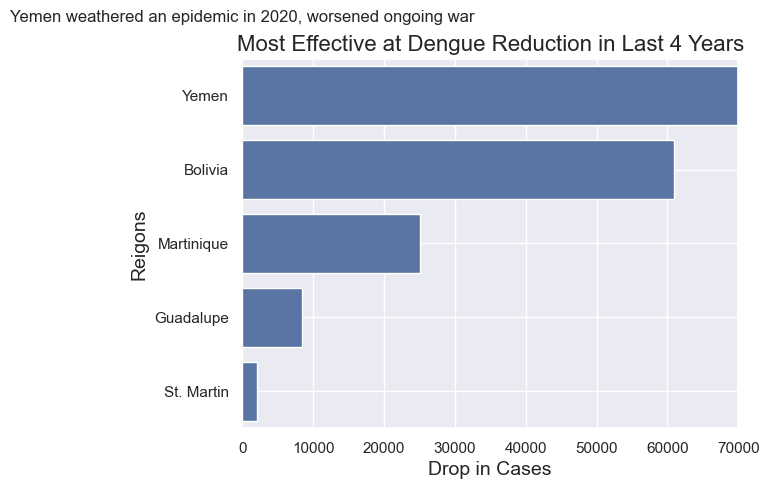

In [29]:
merged_df = pd.merge(cdf.query("Year == 2020"), cdf.query("Year == 2024"), on='Country', suffixes=('_2020', '_2024'))

# calculate the drop in dengue cases
merged_df['Drop'] = merged_df['Dengue_Total_2020'] - merged_df['Dengue_Total_2024']
merged_df = merged_df.sort_values(ascending=False, by='Drop')
subset = merged_df.copy()[0:5]
subset['Full_Names'] = ['Yemen','Bolivia', 'Martinique', 'Guadalupe', 'St. Martin']

# aesthetics for the plot
sns.set(style='darkgrid')
plt = sns.barplot(subset, y="Full_Names", x="Drop")
plt.set(xlim=(0, 70000))
plt.set_title('Most Effective at Dengue Reduction in Last 4 Years', fontsize=16)
plt.set_xlabel('Drop in Cases', fontsize=14)
plt.set_ylabel('Reigons', fontsize=14)
plt.text(x=2.5, y=-1, s="Yemen weathered an epidemic in 2020, worsened ongoing war", ha='center')
plt.grid(axis='y')


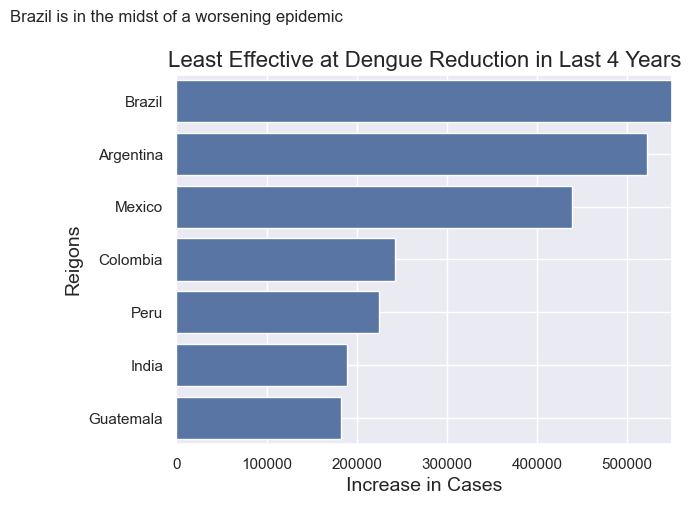

In [30]:
merged_df = pd.merge(cdf.query("Year == 2020"), cdf.query("Year == 2024"), on='Country', suffixes=('_2020', '_2024'))

# calculate the drop in dengue cases
merged_df['Drop'] = merged_df['Dengue_Total_2024'] - merged_df['Dengue_Total_2020']
merged_df = merged_df.sort_values(ascending=False, by='Drop')
subset = merged_df.copy()[0:7]
subset['Full_Names'] = ['Brazil', 'Argentina', 'Mexico', 'Colombia', 'Peru', 'India', 'Guatemala']
subset['Drop'] = abs(subset['Drop'])


# aesthetics for the plot
sns.set(style='darkgrid')
plt = sns.barplot(subset, y="Full_Names", x="Drop")
plt.set(xlim=(0, 550000))
plt.set_title('Least Effective at Dengue Reduction in Last 4 Years', fontsize=16)
plt.set_xlabel('Increase in Cases', fontsize=14)
plt.set_ylabel('Reigons', fontsize=14)
plt.text(x=2.5, y=-1.5, s="Brazil is in the midst of a worsening epidemic", ha='center')
plt.grid(axis='y')


In [31]:
subset

,Country,Year_2020,Dengue_Total_2020,Year_2024,Dengue_Total_2024,Drop,Full_Names
5,BRA,2020,1467142.0,2024,10267077.0,8799935.0,Brazil
1,ARG,2020,59358.0,2024,581559.0,522201.0,Argentina
22,MEX,2020,120639.0,2024,558846.0,438207.0,Mexico
7,COL,2020,78979.0,2024,320982.0,242003.0,Colombia
26,PER,2020,56394.0,2024,280726.0,224332.0,Peru
19,IND,2020,44585.0,2024,233519.0,188934.0,India
15,GTM,2020,6075.0,2024,188585.0,182510.0,Guatemala


## Supervised Learning Approaches: Predicting Total Future Dengue Cases (Regression)

In [32]:
# country list
country_list = list(cdf['Country'].unique()) 
# year we are predicting 
year_index = [2026] * len(country_list)


# making country numerical 
le = LabelEncoder()
# mdf is our machine learning dataset, never work on the clean data directly
mdf = cdf.copy()
mdf['Country_Encoded'] = le.fit_transform(mdf['Country'])

X = mdf[['Year', 'Country_Encoded']]
y = mdf['Dengue_Total']
weights = np.where(y > 100, 1, 10)  # penalizing a few outliers


# train test split
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.2, random_state=67)


# Tried: LinearRegression(), Ridge(alpha=600, fit_intercept=False, tol=0.1)
model = XGBRegressor()
model.fit(X_train, y_train, sample_weight=weights_train)


# y hat for future, 2025-2026 etc. we are setting it to 2026
future_years = pd.DataFrame({
    'Year': year_index,
    'Country_Encoded': le.transform(country_list) # we can use cdf here though, for data pull
})

predictions = model.predict(future_years)

predicted_dfr = pd.DataFrame({'Year': year_index ,'Country': country_list, 'Predicted_Dengue_Total': predictions})
predicted_dfr.tail(3)


,Year,Country,Predicted_Dengue_Total
97,2026,WLF,1527.022827
98,2026,WSM,2216.070312
99,2026,YEM,116972.968750


## Metrics (see how we did)

In [33]:
# ground truth, to check other years change variable yr
yr = 2024
actual = cdf[cdf['Year'] == yr]

# filter actual cases for only the countries that match, we have partial data for many places 
actual_filtered = actual[actual['Country'].isin(country_list)]

# match predictions with actuals, make df
predictions_df = pd.DataFrame({
    'Country': country_list,
    'Predicted_Cases': predictions
})

# only keep the countries that are in actual_filtered
matched_df = predictions_df[predictions_df['Country'].isin(actual_filtered['Country'])]

# sort matched_df based on country_list for consistent ordering
matched_df['Country'] = pd.Categorical(matched_df['Country'], categories=country_list, ordered=True)
matched_df = matched_df.sort_values('Country')

# extract the actual values corresponding to the matched countries
actual_cases_sorted = actual_filtered.set_index('Country').loc[matched_df['Country'], 'Dengue_Total'].values
predictions_sorted = matched_df['Predicted_Cases'].values

# put actual, pred into same dataframe 
matched_df['Actual_Cases'] = actual_cases_sorted
matched_df['Year'] = yr

# calculate MAE and r^2
mae = mean_absolute_error(actual_cases_sorted, predictions_sorted)
r2 = r2_score(actual_cases_sorted, predictions_sorted)

matched_df.tail(5)

/var/folders/gx/2nfqplbd29v32yzcvy4twws80000gn/T/ipykernel_61598/2640629741.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_df['Country'] = pd.Categorical(matched_df['Country'], categories=country_list, ordered=True)


,Country,Predicted_Cases,Actual_Cases,Year
86,TTO,918.680725,2004.0,2024
89,URY,805.631531,712.0,2024
91,VCT,732.539001,971.0,2024
93,VGB,931.397400,139.0,2024
99,YEM,116972.968750,116493.0,2024


In [34]:
print(f'R Squared Value (r2) for predictions: {r2}')

R Squared Value (r2) for predictions: 0.9950036302215381


## Supervised Binary Classification 

In [35]:
le = LabelEncoder()
mdf = cdf.copy()
mdf['Country_Encoded'] = le.fit_transform(mdf['Country'])

# convert to binary classification (high = 1, low = 0)
threshold = 10000  
mdf['Dengue_Class'] = (mdf['Dengue_Total'] > threshold).astype(int)

X = mdf[['Year', 'Country_Encoded']]
y = mdf['Dengue_Class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)


model = XGBClassifier()
model.fit(X_train, y_train)


predictions = model.predict(X_test)


accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# create separate df for actual and predicted values
# inverse transform to get actual country names
decoded_countries = le.inverse_transform(X_test['Country_Encoded'])

predicted_df = pd.DataFrame({
    'Year': X_test['Year'].values,
    'Country': decoded_countries,
    'Actual_Class': y_test.values,
    'Predicted_Class': predictions
})

print('Accuracy:', accuracy)
print('F1 Score:', f1)


Accuracy: 0.9469578783151326
F1 Score: 0.7951807228915663


In [36]:
predicted_df['Actual_Class'] = predicted_df['Actual_Class'].replace({0: 'Low', 1:'High'})
predicted_df['Predicted_Class'] = predicted_df['Predicted_Class'].replace({0: 'Low', 1:'High'})
predicted_df.query("Year == 2024").tail(5)

,Year,Country,Actual_Class,Predicted_Class
192,2024,SLV,Low,Low
307,2024,IND,High,High
358,2024,PER,High,High
435,2024,ATG,Low,Low
534,2024,TTO,Low,Low


## Unsupervised Classification Method 

/Users/pardis/miniconda3/envs/dsan/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


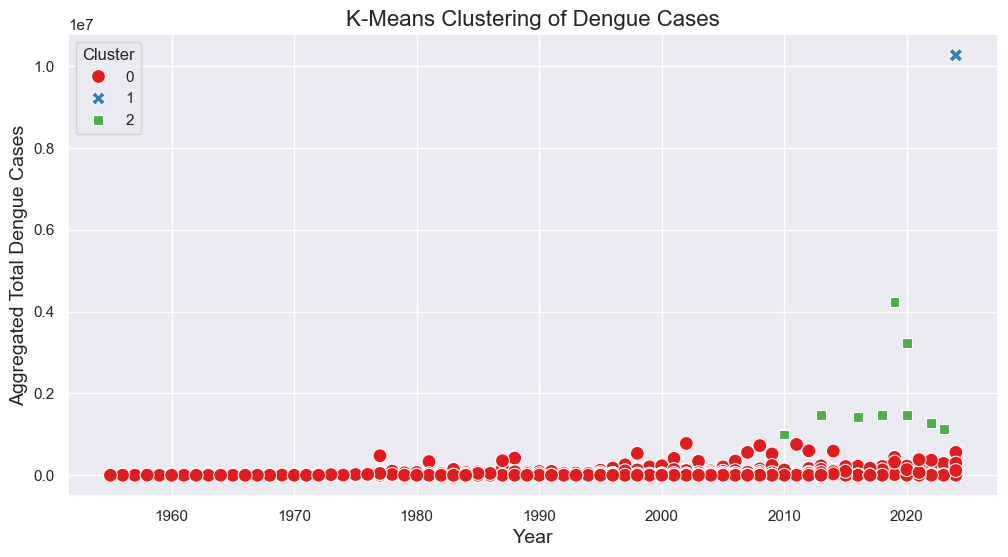

In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt



le = LabelEncoder()
mdf = cdf.copy()
mdf['Country_Encoded'] = le.fit_transform(mdf['Country'])

# feature selection for clustering
X = mdf[['Year', 'Country_Encoded', 'Dengue_Total']]

# number of clusters
n_clusters = 3  # You can adjust this based on your needs

# k means
kmeans = KMeans(n_clusters=n_clusters, random_state=67)
mdf['Cluster'] = kmeans.fit_predict(X)

# actual and predicted values with clusters
decoded_countries = le.inverse_transform(mdf['Country_Encoded'])

clustered_df = pd.DataFrame({
    'Year': mdf['Year'],
    'Country': decoded_countries,
    'Dengue_Total': mdf['Dengue_Total'],
    'Cluster': mdf['Cluster']
})


# plot
sns.set(style='darkgrid')


plt.figure(figsize=(12, 6))
sns.scatterplot(data=clustered_df, x='Year', y='Dengue_Total', hue='Cluster', style='Cluster', palette='Set1', s=100)
plt.title('K-Means Clustering of Dengue Cases', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Aggregated Total Dengue Cases', fontsize=14)
plt.legend(title='Cluster', loc='upper left')
plt.grid(True)
plt.show()
